In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/deps/sparse_rrt-1')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
#from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from plan_utility.line_line_cc import *
import pickle
from sparse_rrt import _deep_smp_module, _sst_module
import os
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (7, 927)]
# (5,931), (6, 286)

obs_idx = 3

p_idx = 1829

# ignore_list = [(8,1914), (0, 1810), (1, 1803), (2, 1809), (3, 1829), (4, 1814), (5, 1826), (7, 1886)]
# found = False
# print(os.path.isfile('/media/arclabdl1/HD1/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/cartpole_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx)))
# for obs_idx in range(6,10):
#     for p_idx in range(1800,2000):
#         if (obs_idx, p_idx) in ignore_list:
#             continue
#         if not os.path.isfile('/media/arclabdl1/HD1/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/cartpole_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx)):
#             continue
#         cost = np.load('/media/arclabdl1/HD1/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/cartpole_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx),
#                allow_pickle=True)[2].sum()
#         data_cost = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/cartpole_obs/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
#         data_cost = pickle.load(data_cost).sum()
#         if cost < 0.4*data_cost:
#             found = True
#             break
#     if found:
#         break

print('obs_idx: ')
print(obs_idx)
print('p_idx:')
print(p_idx)
        

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

obs_idx: 
3
p_idx:
1829
generated.
(7, 2)


In [2]:
# search for goal
"""
for p_idx in range(900,1000):
    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
    sgs = pickle.load(sgs)
    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
    if dis[0] >= np.pi:
        dis[0] = 2*np.pi - dis[0]
    if dis[1] >= np.pi:
        dis[1] = 2*np.pi - dis[1]
        
    if np.linalg.norm(dis) <= 1e-1:
        break
print(p_idx)
"""

"\nfor p_idx in range(900,1000):\n    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')\n    sgs = pickle.load(sgs)\n    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))\n    if dis[0] >= np.pi:\n        dis[0] = 2*np.pi - dis[0]\n    if dis[1] >= np.pi:\n        dis[1] = 2*np.pi - dis[1]\n        \n    if np.linalg.norm(dis) <= 1e-1:\n        break\nprint(p_idx)\n"

In [3]:

params = {
        'n_problem': 1,
        'n_sample': 1024,
        'n_elite': 128,
        'n_t': 1,
        'max_it': 250,
        #'converge_r': 5e-1,
        'converge_r': 1e-5,
    
        'dt': 2e-3,
        'mu_u': np.array([0.]),
        'sigma_u': np.array([400]),
        'mu_t': 4e-1,
        'sigma_t': 4e-1,
        't_max': 0.6,

        'verbose': True,# False,#
        'step_size': 0,

        "goal_radius": 1.5,

        "sst_delta_near": 1,
        "sst_delta_drain": 1e-1,
        "goal_bias": 0.0,

        "width": 4,
        "hybrid": False,#True,# 
        "hybrid_p": 0.0,
        
        "min_time_steps": 5,
        "max_time_steps": 100,
    
        "cost_samples": 1,
        "mpnet_weight_path":"/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/mpnet_10k_external_small_model.pt",
        "cost_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_10k.pt",
        "cost_to_go_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0,
        "refine_threshold": 0,
        "device_id": "cuda:3",

        "cost_reselection": False,
        "number_of_iterations": 2000,
        "weights_array": [1, .5, 1, .5],

    }

In [4]:
# load path
path, control, time = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/cartpole_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx),
               allow_pickle=True)

sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/cartpole_obs/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)
print(sgs)
"""
# (7, 927)
path = np.array(
[[ 0.,          0.,          0.,          0.        ],
 [-0.30235064,  0.66357245, -1.12404058,  2.63216073],
 [-0.42513114,  0.98700913, -0.29263858,  1.22161321],
 [ 0.81097696, -2.21064598, -1.87366238, -0.44346807],
 [ 0.43625224, -2.17189627, -2.81821699,  1.07151433],
 [ 1.30897045,  2.50860498,  0.25455659, -1.13373327],
 [ 1.30296453,  2.41413713, -0.5262052, -0.66861023],
 [-1.58742542, -1.43178197, -2.36883756,  4.15048263],
 [-1.88335465, -0.77853767, -0.38750337,  2.06091217],
 [ 1.86185939, -1.89328253,  1.66468725,  3.40569328],
 [ 1.88586336, -0.82441263, -1.47474734,  5.44456514],
 [ 3.02422565,  2.29042714, -1.37086011,  0.0215158 ],
 [ 2.59949331,  2.31621808, -1.51831319,  0.3535678 ],
 [ 2.42948197,  2.37665629, -2.00484496,  0.99423899],
 [-1.57991341, -1.36811145, -2.2772159,   2.70299448],
 [ 2.80394195,  0.71981286,  1.12148533, -1.98584426],
 [ 3.00295891,  0.34951812,  0.73202747, -1.4486524 ],
 [ 3.13364725,  0.10208493, -0.41396637,  0.97824909]])

# (1, 916)
path = np.array(
 [[ 0.,          0.,          0.,          0.        ],
 [-0.14637182,  0.36741907,  0.16802393, -0.09198922],
 [ 0.33910537, -0.53233128,  1.01860863, -2.2462016 ],
 [ 0.45433237, -0.84326897,  0.00979799, -0.67701909],
 [ 0.15750956, -0.76430055, -1.76589893,  2.27511201],
 [ 0.05599173,  2.06468595,  2.89323376, -1.13509309],
 [ 0.70446343,  1.75184533,  1.34005915, -0.63608721],
 [-0.6347062,  -3.02094395, -3.14349578,  2.88615537],
 [-1.29986757, -2.26094529, -0.70598324,  1.6203048 ],
 [ 1.52734201,  1.99942129,  2.90282734, -3.52070003],
 [ 1.89659985,  1.48138215,  1.52561572, -2.66617007],
 [ 2.02352651,  1.23006466,  0.90312322, -2.28778868],
 [ 2.09466351,  0.73102972, -0.39847056, -1.59188   ],
 [ 2.07385742,  0.67449809, -0.88810876, -0.87647985]])
"""
# (8, 914)
"""
path = np.array(
[[ 0.,          0.,          0.,          0.        ],
 [ 0.1708568,  -0.39391056,  0.19467657, -0.62469995],
 [ 0.28792115, -0.91607445,  0.44898465, -1.63658985],
 [-0.95989468,  1.96289103,  0.9317956,   1.43428469],
 [-0.30129242,  2.94121546, -1.83117369,  0.90737314],
 [-0.70691949, -3.12132232, -1.05535802,  0.6535526 ],
 [-0.82442304, -3.03540106,  0.01787491,  0.13220202],
 [ 0.52775011,  2.27083079,  0.37915111, -0.44081038],
 [-1.07891294, -2.37855552, -0.30601515,  1.50195129],
 [ 1.64625095,  2.19734582,  1.28417728, -1.54819197],
 [ 1.75929464,  2.02474293,  0.19036604, -0.80510894],
 [-1.9036383,  -1.9494513,  -1.02537086,  0.82188096],
 [ 2.3872588,   1.49882542,  1.73340551, -2.18197651],])
"""

[array([21.61279251,  0.        ,  1.52666725,  0.        ]), array([-23.15280384, -34.14387832,  -2.43323525,   0.43542129])]


'\npath = np.array(\n[[ 0.,          0.,          0.,          0.        ],\n [ 0.1708568,  -0.39391056,  0.19467657, -0.62469995],\n [ 0.28792115, -0.91607445,  0.44898465, -1.63658985],\n [-0.95989468,  1.96289103,  0.9317956,   1.43428469],\n [-0.30129242,  2.94121546, -1.83117369,  0.90737314],\n [-0.70691949, -3.12132232, -1.05535802,  0.6535526 ],\n [-0.82442304, -3.03540106,  0.01787491,  0.13220202],\n [ 0.52775011,  2.27083079,  0.37915111, -0.44081038],\n [-1.07891294, -2.37855552, -0.30601515,  1.50195129],\n [ 1.64625095,  2.19734582,  1.28417728, -1.54819197],\n [ 1.75929464,  2.02474293,  0.19036604, -0.80510894],\n [-1.9036383,  -1.9494513,  -1.02537086,  0.82188096],\n [ 2.3872588,   1.49882542,  1.73340551, -2.18197651],])\n'

In [5]:
planner = _deep_smp_module.DSSTMPCWrapper(
    system_type='cartpole_obs',
    solver_type="cem",
    start_state=np.array(path[0]),
#             goal_state=np.array(ref_path[-1]),
    goal_state=np.array(sgs[-1]),
    goal_radius=params['goal_radius'],
    random_seed=0,
    sst_delta_near=params['sst_delta_near'],
    sst_delta_drain=params['sst_delta_drain'],
    obs_list=obs_list,
    width=params['width'],
    verbose=params['verbose'],
    mpnet_weight_path=params['mpnet_weight_path'], 
    cost_predictor_weight_path=params['cost_predictor_weight_path'],
    cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
    num_sample=params['cost_samples'],
    np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
    converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
    std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
    device_id=params['device_id'], refine_lr=params['refine_lr'],
    weights_array=params['weights_array'],
    obs_voxel_array=obc_list.reshape(-1)
)

In [6]:
from plan_utility.line_line_cc import line_line_cc


def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """

    if state[STATE_V] < MIN_V:
        new_state[STATE_V] = MIN_V
    elif state[STATE_V] > MAX_V:
        new_state[STATE_V] = MAX_V

    if state[STATE_THETA] < -np.pi:
        new_state[STATE_THETA] += 2*np.pi
    elif state[STATE_THETA] > np.pi:
        new_state[STATE_THETA] -= 2*np.pi

    if state[STATE_W] < MIN_W:
        new_state[STATE_W] = MIN_W
    elif state[STATE_W] > MAX_W:
        new_state[STATE_W] = MAX_W
    return new_state


def IsInCollision(x, obc, obc_width=4.):
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5

    STATE_X = 0
    STATE_V = 1
    STATE_THETA = 2
    STATE_W = 3
    CONTROL_A = 0

    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2


    if x[0] < MIN_X or x[0] > MAX_X:
        return True

    H = 0.5
    pole_x1 = x[0]
    pole_y1 = H
    pole_x2 = x[0] + L * np.sin(x[2])
    pole_y2 = H + L * np.cos(x[2])


    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False


In [7]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [8]:
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
class CartpoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartpoleVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig1 = plt.figure(figsize=(25,6))
        self.fig2 = plt.figure(figsize=(25,20))
        self.ax1 = self.fig1.add_subplot(1,1,1)
        self.ax2 = self.fig2.add_subplot(1,1,1)

    def _init(self):
        ##### handle the animation
        # clear the current ax
        print("in init")
        ax = self.ax1
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor=self.color_dict['pole_start_color'],\
                                      facecolor=self.color_dict['pole_start_color'])
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['cart_start_color'],\
                                      facecolor=self.color_dict['cart_start_color'])
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['obstacle_color'],\
                                      facecolor=self.color_dict['obstacle_color'])
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)

        #### handle search space
        ax = self.ax2
        ax.clear()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-np.pi, np.pi)

        dx = 1
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*30./dx)
        jmin = 0
        jmax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(jmin, jmax):
                x = np.array([dx*i-30, 0., dtheta*j-np.pi, 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)
        
        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,2], c='yellow')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,2], c=self.color_dict['obstacle_color'])

        #self.recs.append(scat_feas)
        self.recs.append(scat_infeas)

        scat_state = ax.scatter(state[0], state[2], c=self.color_dict['state_start_color'])
        self.recs.append(scat_state)
        print("after init")

        return self.recs
    def _animate(self, i):
        print('animating, frame %d/%d' % (i, self.total))
        
        ax = self.ax1
        ax.set_xlim(-25, 25)
        ax.set_ylim(-6, 6)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,0))


        # handle search space
        ax = self.ax2
        ax.set_xlim(-25, 25)
        ax.set_ylim(-np.pi, np.pi)
        self.recs[-1].set_offsets([state[0], state[2]])
        # print location of cart
        return self.recs


    def animate(self, states, actions, costs, obstacles, sg, wrap_system):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 4.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            s = states[i]
            print('state: %d, remaining: %d' % (i, len(states)-i))
            #action = actions[i]
            
            # connect from this state to next
            solution_u, solution_t = planner.steer_solution(states[i], states[i+1])
            print('solution_u:')
            print(solution_u)
            print('solution_t:')
            print(solution_t)
            for j in range(len(solution_u)):
                action = solution_u[j]
                num_steps = int(np.round(solution_t[j]/self.params['integration_step']))

                for k in range(num_steps):
                    traj.append(np.array(s))
                    #print("porpagating...")
                    #print(s)
                    #print('st:')
                    #print(sT)
                    s = self.system(s, action, self.params['integration_step'])
                    s = enforce_bounds(s)
                    assert not IsInCollision(s, obs_i)
            print('after propagation, state: ', s)
            print('state to reach: ', states[i+1])
        return np.array(traj)
    
    # plot the trajectory
    def plot(self, traj, obstacles, sg, color_dict, wrap_system):
        self.fig1 = plt.figure(figsize=(25,6))
        self.fig2 = plt.figure(figsize=(25,20))
        self.ax1 = self.fig1.add_subplot(1,1,1)
        self.ax2 = self.fig2.add_subplot(1,1,1)
        self.color_dict = color_dict
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        traj_recs = []
        plot_step_sz = 50
        for i in list(range(1,len(traj))) + [0]:
            if i % plot_step_sz == 0:
                # plot the scene change
                if i == 0:
                    pole_color = color_dict["pole_start_color"]
                    cart_color = color_dict["cart_start_color"]
                elif i+plot_step_sz >= len(traj):
                    pole_color = color_dict["pole_goal_color"]
                    cart_color = color_dict["cart_goal_color"]
                else:
                    pole_color = color_dict["pole_intermediate_color"]
                    cart_color = color_dict["cart_intermediate_color"]
                state = traj[i]
                pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                               self.params['pole_w'],self.params['pole_l'],\
                                              linewidth=.5,edgecolor=pole_color,facecolor=pole_color)
                cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                               self.params['cart_w'],self.params['cart_h'],\
                                              linewidth=.5,edgecolor=cart_color,facecolor=cart_color)

                traj_recs.append(pole)
                traj_recs.append(cart)
                ax = self.ax1
                ax.set_xlim(-25, 25)
                ax.set_ylim(-6, 6)
                ax.add_patch(pole)
                ax.add_patch(cart)
                pole.set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
                t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                                -state[2]/np.pi * 180) + ax.transData
                pole.set_transform(t)
                cart.set_xy((state[0]-self.params['cart_w']/2,0))
                ax.axis('off')

            # plot in the state space    
            ax = self.ax2
            traj_to_plot = wrap_angle(traj[i], wrap_system)
            scat_state = ax.scatter(traj_to_plot[0], traj_to_plot[2], c=color_dict['state_intermediate_color'], s=25.0)
        colors = [color_dict["state_start_color"], color_dict["state_goal_color"]]
        
        #ax = self.ax1
        #cm = LinearSegmentedColormap.from_list("Custom", colors, N=len(to_plot_list_x))
        """
        for i in range(len(to_plot_list_x)):
            #ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=cm(float(i)/len(to_plot_list_x)))
            if i == 0:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=1, c='green')
            else:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c='blue')
        """
            
        # start and goal
        ax = self.ax2
        scat_state = ax.scatter(sg[0][0], sg[0][2], c=color_dict["state_start_color"], s=200.0)
        scat_state = ax.scatter(sg[1][0], sg[1][2], c=color_dict["state_goal_color"], s=200.0, marker='*')
        plt.subplots_adjust(wspace=0, hspace=0)

        ax.axis('off')

        #plt.savefig("cartpole_mpnettree_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
        return self.fig1, self.fig2
#         self.fig1.savefig("cartpole_mpnettree_%d_p_%d_workspace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
#         self.fig2.savefig("cartpole_mpnettree_%d_p_%d_statespace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
#         self.fig1.show()
#         self.fig2.show()
        
        """
        # for thesis
        fig = plt.figure()
        ax = plt.subplot(121)
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        ax.plot(to_plot_list_x[0], to_plot_list_y[0], alpha=1, c='green')
        ax.plot(to_plot_list_x[-1], to_plot_list_y[-1], alpha=1, c='red')
        
        ax = plt.subplot(122)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='black')
        scat_state = ax.scatter(sg[0][0], sg[0][1], c='green', s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c='red', s=50.0, marker='*')
        """


states:
[[ 2.16127925e+01  0.00000000e+00  1.52666725e+00  0.00000000e+00]
 [ 1.81056202e+01 -1.16069728e+01  1.12304087e+00 -1.09157572e+00]
 [ 1.32454717e+01 -4.51228019e+00  2.16832720e-02 -2.00000000e+00]
 [ 1.27932889e+01  1.71642071e+00 -7.38316728e-01 -2.00000000e+00]
 [ 1.40054858e+01  6.45240631e+00 -1.31935471e+00 -1.86417600e+00]
 [ 1.41492520e+01 -5.68412176e+00 -1.91100238e+00 -5.30200926e-01]
 [ 1.06913346e+01 -1.19005826e+01 -2.05095649e+00 -2.29337817e-01]
 [ 1.20878967e+00 -1.97346203e+01 -2.06534509e+00  1.75615280e-01]
 [-1.42277323e+01 -3.17384573e+01 -1.97124933e+00  2.01978240e-01]
 [-1.85192684e+01 -3.43243052e+01 -1.94129059e+00  2.64290592e-01]
 [-2.17936903e+01 -3.38888816e+01 -1.90116705e+00  5.77435983e-01]]
state: 0, remaining: 11
solution_u:
[[-300.]]
solution_t:
[0.6]
after propagation, state:  [ 18.10559197 -11.60706846   1.12304177  -1.09157114]
state to reach:  [ 18.10562019 -11.60697279   1.12304087  -1.09157572]
state: 1, remaining: 10
solution_u:
[[

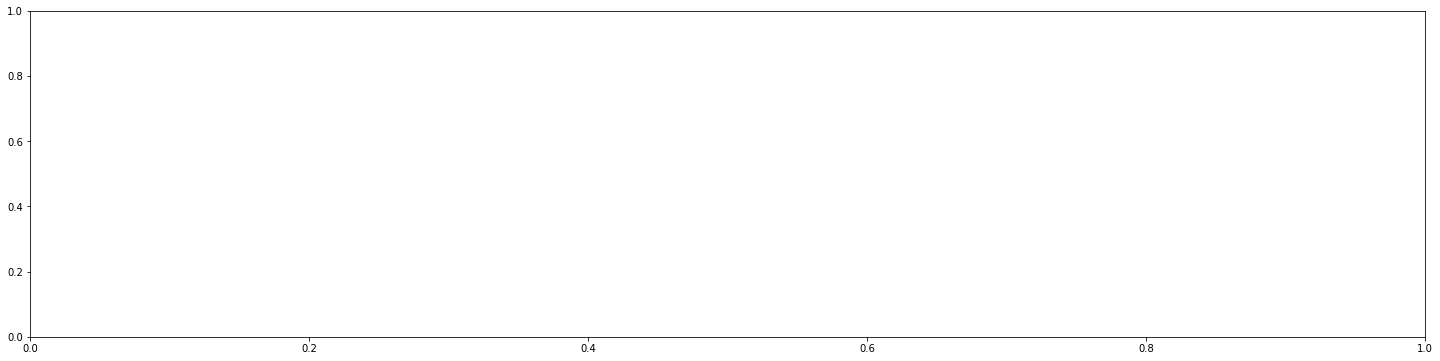

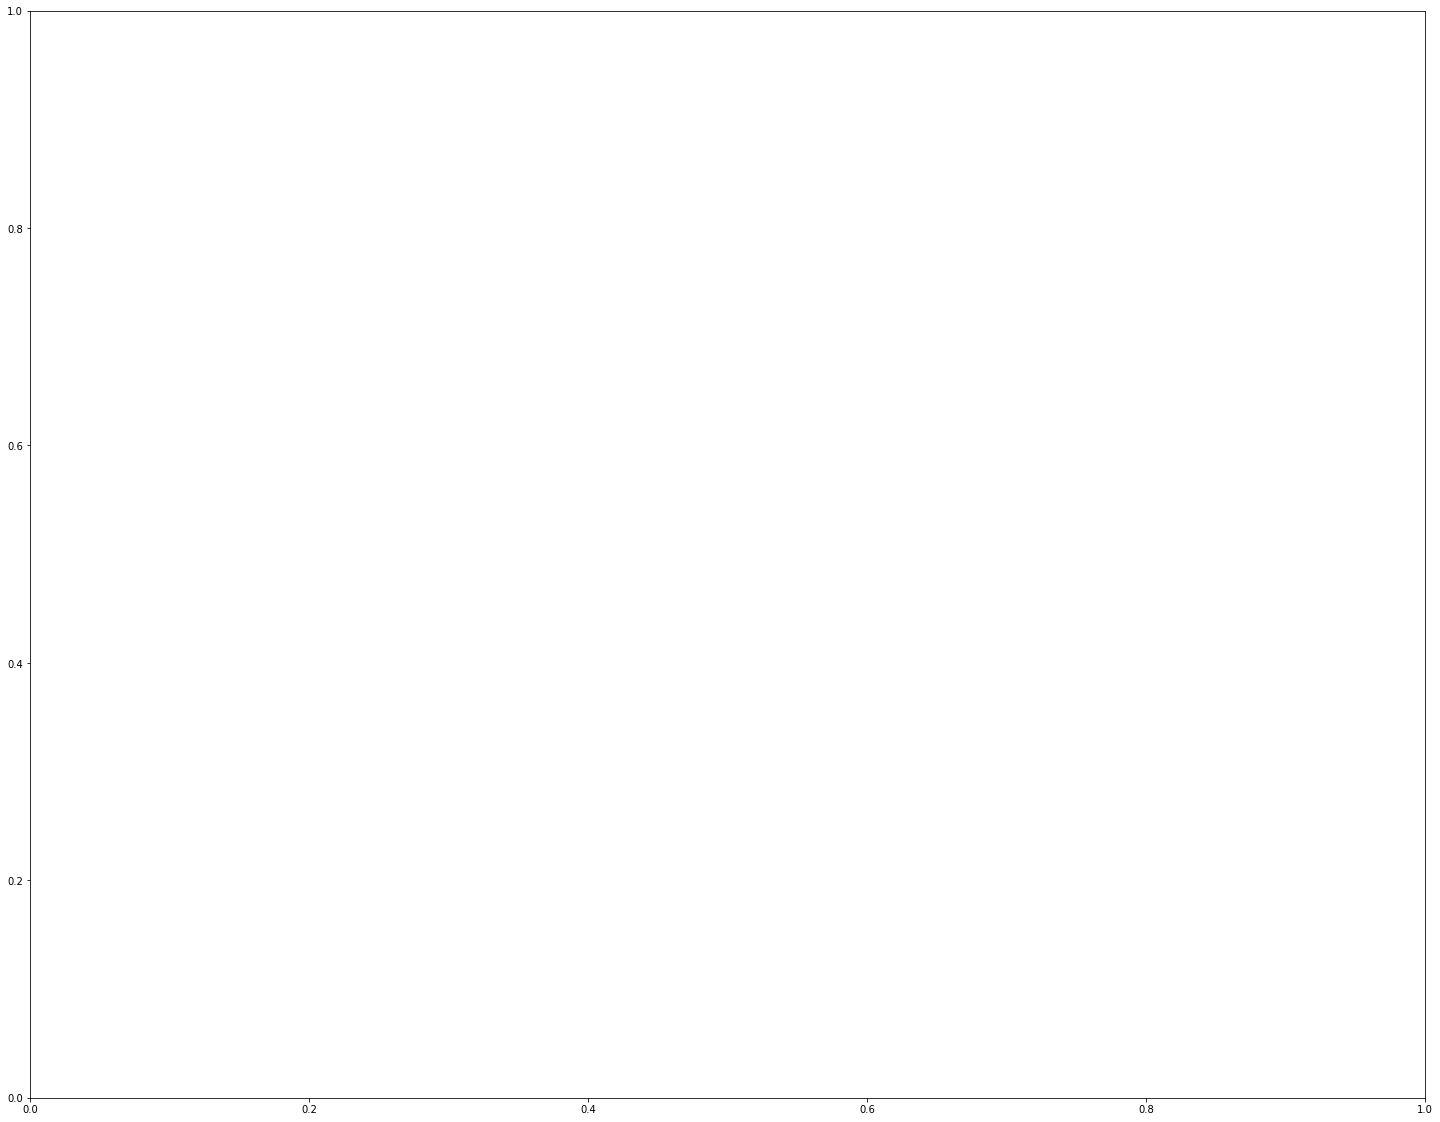

In [9]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.01
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
system = _sst_module.CartPole()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = CartpoleVisualizer(dynamics, params)
states = path
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), None, None, obs_list, np.array(sgs), system)
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

animating...
2145
in init
feasible points
[[-30.           0.          -3.14159265   0.        ]
 [-30.           0.          -3.04159265   0.        ]
 [-30.           0.          -2.94159265   0.        ]
 ...
 [ 29.           0.           2.75840735   0.        ]
 [ 29.           0.           2.85840735   0.        ]
 [ 29.           0.           2.95840735   0.        ]]
infeasible points
[[-19.           0.           0.75840735   0.        ]
 [-19.           0.           0.85840735   0.        ]
 [-19.           0.           0.95840735   0.        ]
 ...
 [ 12.           0.          -1.04159265   0.        ]
 [ 12.           0.          -0.94159265   0.        ]
 [ 12.           0.          -0.84159265   0.        ]]
after init


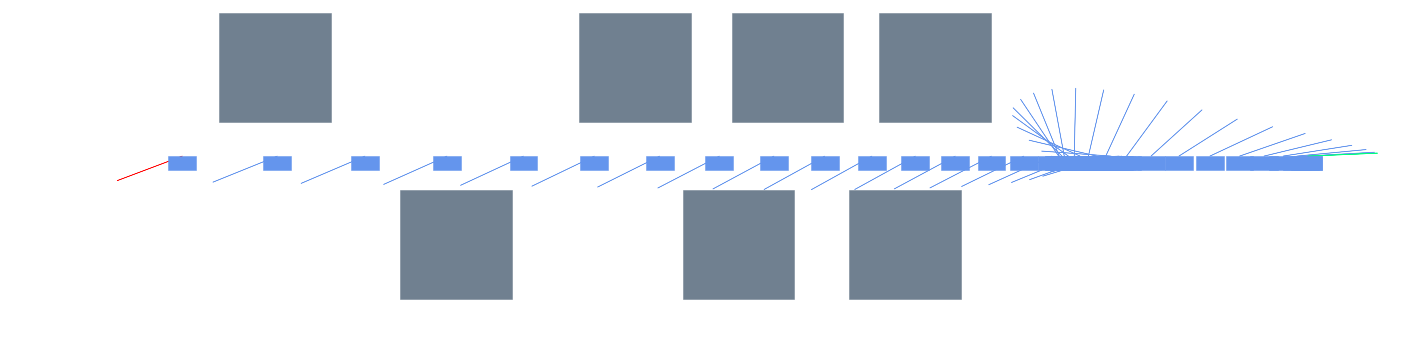

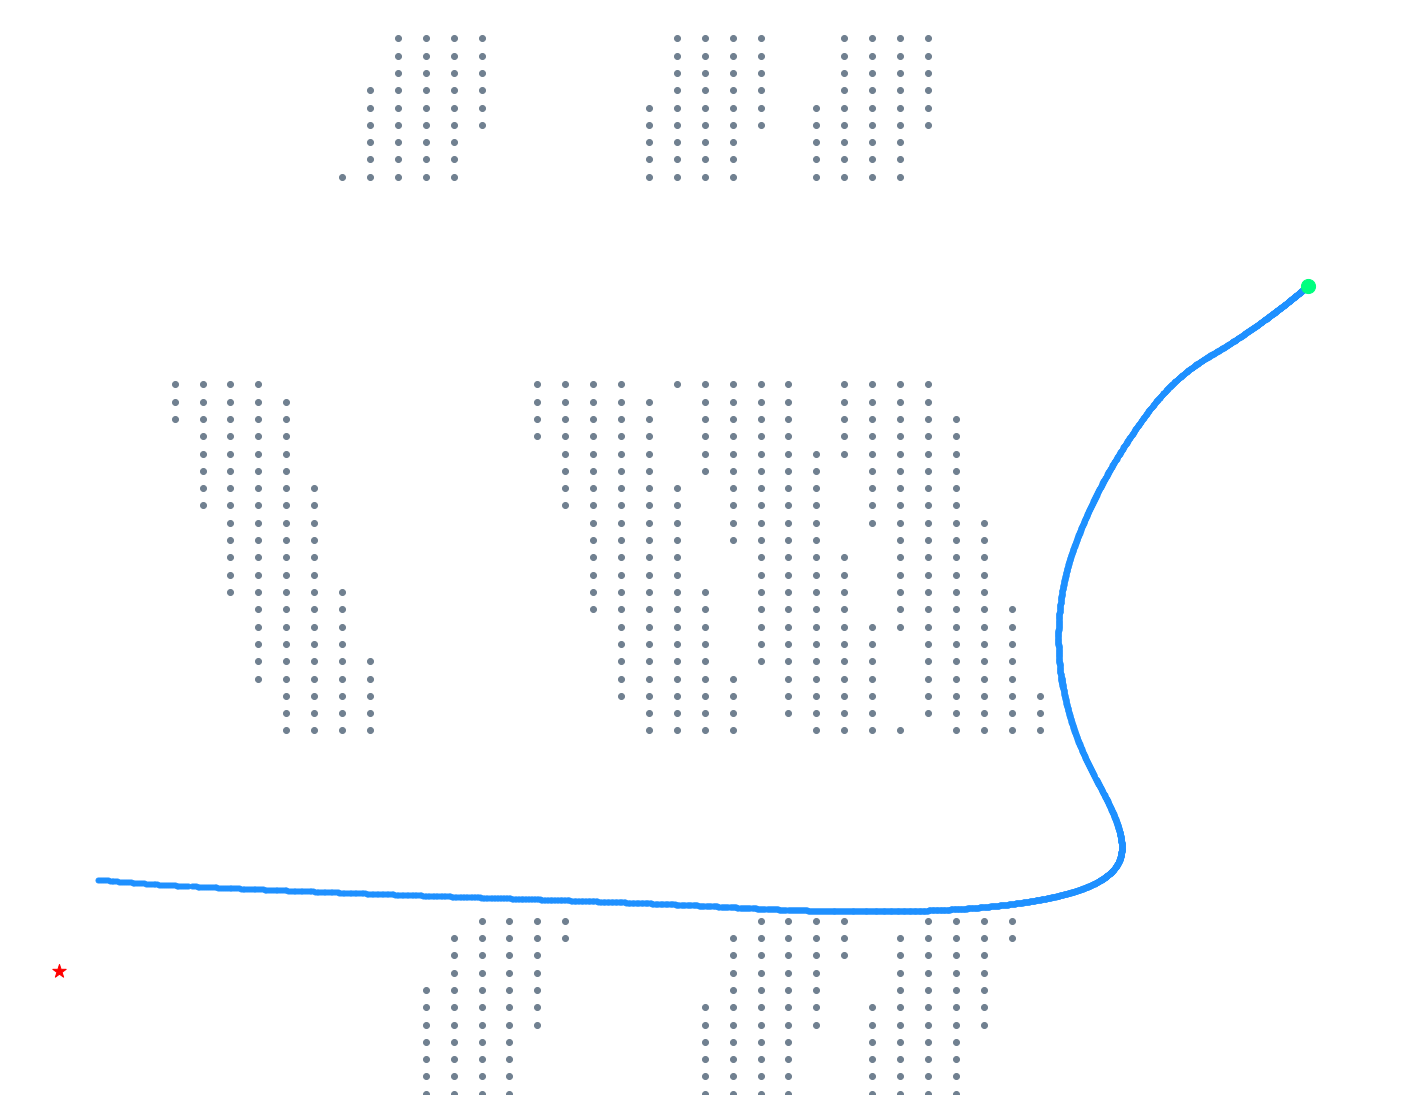

In [17]:
color_dict = {'state_start_color': 'springgreen', 'state_intermediate_color': 'dodgerblue', 'state_goal_color': 'red',
              'pole_start_color': 'springgreen', 'pole_intermediate_color': 'cornflowerblue', 'pole_goal_color': 'red',
              'cart_start_color': 'cornflowerblue', 'cart_intermediate_color': 'cornflowerblue', 'cart_goal_color': 'cornflowerblue',
              'obstacle_color': 'slategray'}
fig1, fig2 = vis.plot(traj, obs_list, np.array(sgs), color_dict, system)
fig1.savefig("cartpole_mpnettree_%d_p_%d_workspace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
fig2.savefig("cartpole_mpnettree_%d_p_%d_statespace.pdf" % (obs_idx, p_idx), bbox_inches='tight', pad_inches = 0)
fig1.show()
fig2.show()


In [11]:
print(obs_idx)
print(p_idx)


3
1829
